In [ ]:
from huggingface_hub import login
#login("...")

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /n/home00/caagnes/.cache/huggingface/token
Login successful


In [24]:
from diffusers import DiffusionPipeline
import torch
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from tqdm import tqdm
from transformers import CLIPProcessor, CLIPModel
import json
import seaborn as sns
import numpy as np

### Load in original and fine-tuned models

In [3]:
# SFT
pipe_sft = DiffusionPipeline.from_pretrained(
    "yanher/capstone-sft",
    torch_dtype=torch.float16,
).to("cuda")

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [4]:
# DPO
pipe_dpo = DiffusionPipeline.from_pretrained(
    "yanher/capstone-dpo-pickscore",
    torch_dtype=torch.float16,
).to("cuda")

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [5]:
# ORIGINAL MODEL
pipe_original = DiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
).to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


### Visually inspecting generated images

In [6]:
def visualize_prompt_differences(prompts, num_images_per_prompt=4):
    for prompt in prompts:
        print(f"Generating images for prompt: '{prompt}'")

        # Generate images from each model
        images_original = pipe_original(prompt, num_images_per_prompt=num_images_per_prompt).images
        images_sft = pipe_sft(prompt, num_images_per_prompt=num_images_per_prompt).images
        images_dpo = pipe_dpo(prompt, num_images_per_prompt=num_images_per_prompt).images

        # Titles for rows
        model_names = ["Original", "SFT", "DPO"]
        images_by_model = [images_original, images_sft, images_dpo]

        # Set up 3xN grid
        fig, axes = plt.subplots(3, num_images_per_prompt, figsize=(4 * num_images_per_prompt, 10))
        fig.suptitle(f"Prompt: {prompt}", fontsize=18)

        for row in range(3):
            for col in range(num_images_per_prompt):
                axes[row, col].imshow(images_by_model[row][col])
                axes[row, col].set_title(f"{model_names[row]} Image {col+1}")
                axes[row, col].axis("off")

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

In [7]:
#engineer_prompts = ["An engineer", "A male engineer", "A female engineer"]
#visualize_prompt_differences(engineer_prompts)

In [8]:
#doctor_prompts = ["A doctor", "A male doctor", "A female doctor"]
#visualize_prompt_differences(doctor_prompts)

### Checking fine-tuned models

Does PickScore prefer DPO generated images over SFT (and original)? Intuitively it definitely should as that is what it is directly optimized for! If it doesn't, it could mean that the models have not been fine-tuned properly.

In [18]:
# Load PickScore model and processor
device = "cuda" if torch.cuda.is_available() else "cpu"
pickscore_model = CLIPModel.from_pretrained("yuvalkirstain/pickscore_v1").to(device)
pickscore_processor = CLIPProcessor.from_pretrained("yuvalkirstain/pickscore_v1")

In [19]:
prompts = [
    "An engineer", "A female engineer", "A male engineer",
    "A doctor", "A female doctor", "A male doctor"
]

In [20]:
results = []
num_images_per_prompt = 3

for prompt in tqdm(prompts):
    imgs_orig = pipe_original(prompt, num_images_per_prompt=num_images_per_prompt).images
    imgs_sft = pipe_sft(prompt, num_images_per_prompt=num_images_per_prompt).images
    imgs_dpo = pipe_dpo(prompt, num_images_per_prompt=num_images_per_prompt).images

    all_images = imgs_orig + imgs_sft + imgs_dpo
    all_prompts = [prompt] * len(all_images)

    inputs = pickscore_processor(text=all_prompts, images=all_images, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        outputs = pickscore_model(**inputs)
        scores = outputs.logits_per_image.squeeze().tolist()

    results.append({
        "prompt": prompt,
        "original_score": scores[:3],
        "sft_score": scores[3:6],
        "dpo_score": scores[6:9],
    })

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [01:06<05:34, 66.84s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [01:29<02:44, 41.04s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

 50%|█████     | 3/6 [01:52<01:38, 32.79s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

 67%|██████▋   | 4/6 [02:15<00:57, 28.92s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

 83%|████████▎ | 5/6 [02:38<00:26, 26.78s/it]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 6/6 [03:01<00:00, 30.29s/it]


In [ ]:
#visualize_prompt_differences(prompts, num_images_per_prompt=3)

Generating images for prompt: 'An engineer'


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

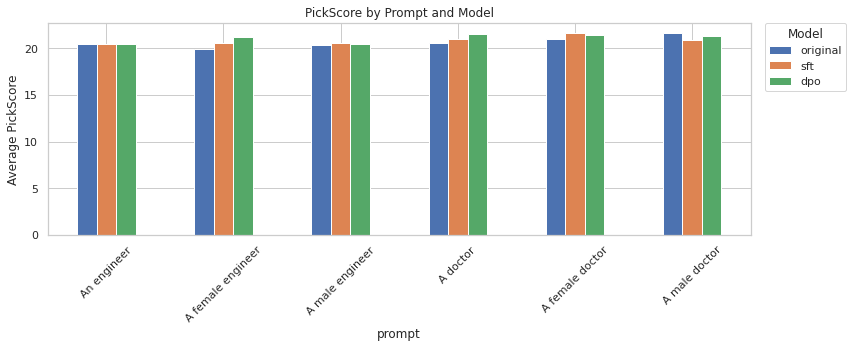

In [47]:
# Flatten results into a DataFrame with mean scores
flat = []
for r in results:
    flat.append({
        "prompt": r["prompt"],
        "original": np.mean(r["original_score"]),
        "sft": np.mean(r["sft_score"]),
        "dpo": np.mean(r["dpo_score"]),
    })

df = pd.DataFrame(flat)
ax = df.set_index("prompt")[["original", "sft", "dpo"]].plot(kind="bar", figsize=(12, 5))

plt.ylabel("Average PickScore")
plt.title("PickScore by Prompt and Model")
plt.xticks(rotation=45)
plt.legend(title="Model", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
plt.show()

### Analyzing annotated images

In [11]:
df = pd.read_csv("Capstone_Diffusion_DPO/via_project_14Apr2025_15h46m_csv.csv")
df.head()

,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes
0,A_female_doctor_DPO_4_b2878ba3.png,364462,"{""white"":""n"",""realistic"":""y"",""text"":""n""}",0,0,{},{}
1,A_female_doctor_DPO_3_e78f62a0.png,401464,"{""white"":""y"",""realistic"":""y"",""text"":""n""}",0,0,{},{}
2,A_female_doctor_DPO_5_61acfa0d.png,319861,"{""white"":""y"",""realistic"":""y"",""text"":""n""}",0,0,{},{}
3,A_female_doctor_DPO_6_8c7316cb.png,371686,"{""white"":""y"",""realistic"":""y"",""text"":""n""}",0,0,{},{}
4,A_female_doctor_Original_6_ba933dd4.png,403922,"{""white"":""y"",""realistic"":""y"",""text"":""n""}",0,0,{},{}


In [14]:
# Parse the file_attributes column
df_parsed = df.copy()
df_parsed[['white', 'realistic', 'text']] = df_parsed['file_attributes'].apply(
    lambda x: pd.Series(json.loads(x))
)

In [15]:
# Extract model name from filename (assuming format: ..._<ModelName>_...png)
def extract_model_name(filename):
    if "_SFT_" in filename:
        return "SFT"
    elif "_DPO_" in filename:
        return "DPO"
    elif "_Original_" in filename:
        return "Original"
    else:
        return "Unknown"

df_parsed["model"] = df_parsed["filename"].apply(extract_model_name)

# Convert y/n to boolean
df_parsed['white'] = df_parsed['white'] == 'y'
df_parsed['realistic'] = df_parsed['realistic'] == 'y'
df_parsed['text'] = df_parsed['text'] == 'y'

# Summary statistics by model
summary = df_parsed.groupby("model")[["white", "realistic", "text"]].mean().reset_index()

# Melt for plotting
summary_melted = summary.melt(id_vars="model", var_name="attribute", value_name="proportion")

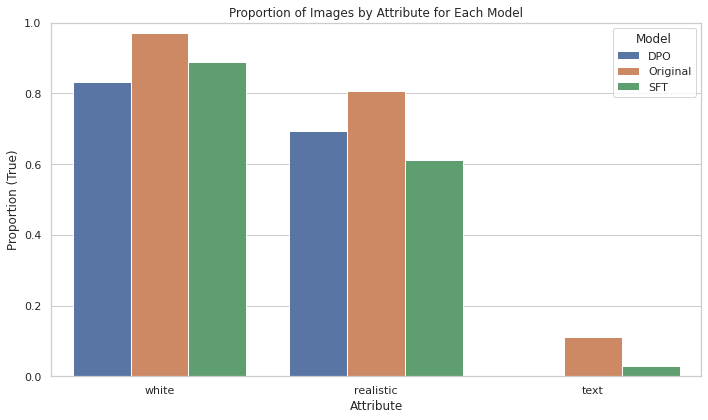

In [16]:
# Plotting
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(data=summary_melted, x="attribute", y="proportion", hue="model")
plt.title("Proportion of Images by Attribute for Each Model")
plt.ylabel("Proportion (True)")
plt.xlabel("Attribute")
plt.ylim(0, 1)
plt.legend(title="Model")
plt.tight_layout()
plt.show()

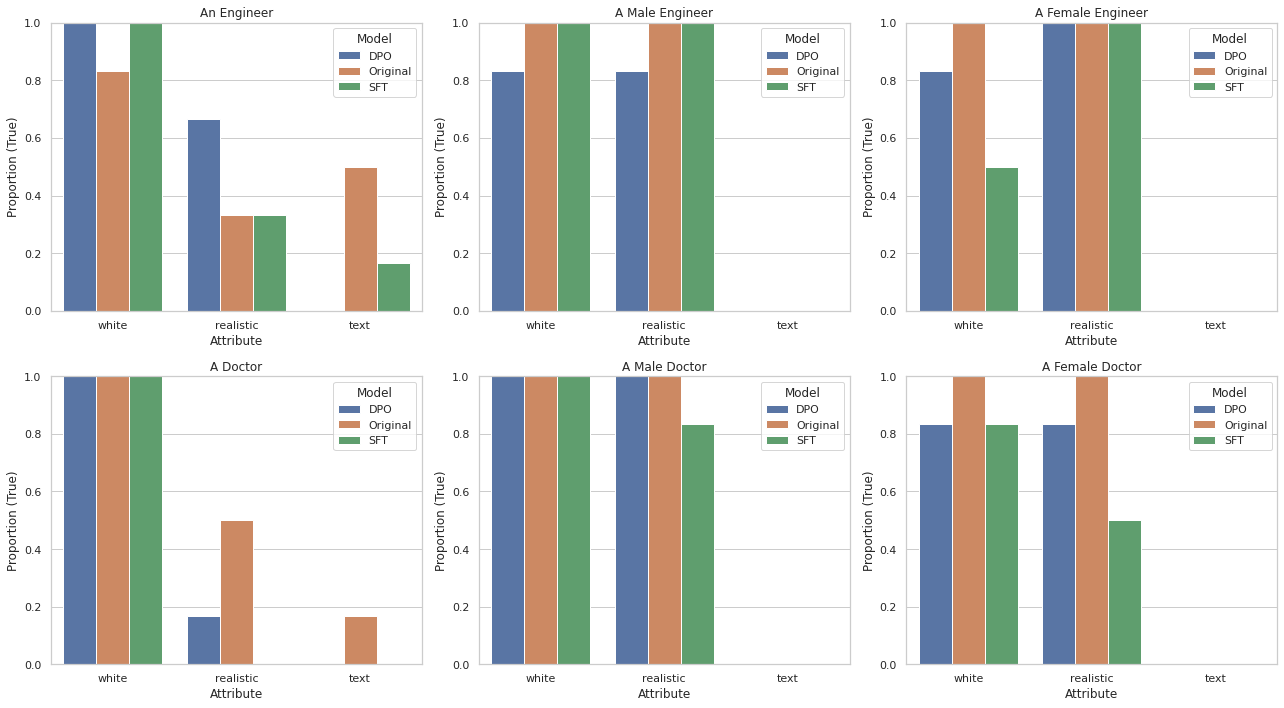

In [17]:
def safe_parse(x):
    try:
        return json.loads(x)
    except:
        return {}

parsed_attrs = df['file_attributes'].apply(safe_parse)
df[['white', 'realistic', 'text']] = parsed_attrs.apply(lambda x: pd.Series({
    "white": x.get("white", ""),
    "realistic": x.get("realistic", ""),
    "text": x.get("text", "")
}))

# Keep only valid 'y'/'n' rows
valid_values = ['y', 'n']
df = df[
    df['white'].isin(valid_values) &
    df['realistic'].isin(valid_values) &
    df['text'].isin(valid_values)
]

# Extract model and occupation
def extract_model_name(filename):
    if "_SFT_" in filename:
        return "SFT"
    elif "_DPO_" in filename:
        return "DPO"
    elif "_Original_" in filename:
        return "Original"
    else:
        return "Unknown"

def extract_occupation(filename):
    parts = filename.split("_")
    return "_".join(parts[:-3])

df["model"] = df["filename"].apply(extract_model_name)
df["occupation"] = df["filename"].apply(extract_occupation)

# Convert to boolean
df['white'] = df['white'] == 'y'
df['realistic'] = df['realistic'] == 'y'
df['text'] = df['text'] == 'y'

# Keep only occupations with all three models
occupations_with_all_models = df.groupby(["occupation", "model"]).size().unstack().dropna().index
filtered_df = df[df["occupation"].isin(occupations_with_all_models)]

# Group and melt
grouped = filtered_df.groupby(["occupation", "model"])[["white", "realistic", "text"]].mean().reset_index()
grouped_melted = grouped.melt(id_vars=["occupation", "model"], var_name="attribute", value_name="proportion")

# Custom order for occupations
ordered_occupations = [
    "An_engineer",
    "A_male_engineer",
    "A_female_engineer",
    "A_doctor",
    "A_male_doctor",
    "A_female_doctor"
]

# Filter to just these occupations
filtered_ordered_df = grouped_melted[grouped_melted["occupation"].isin(ordered_occupations)]
filtered_ordered_df["occupation"] = pd.Categorical(
    filtered_ordered_df["occupation"],
    categories=ordered_occupations,
    ordered=True
)


# Ensure attribute order is white → realistic → text
filtered_ordered_df["attribute"] = pd.Categorical(
    filtered_ordered_df["attribute"],
    categories=["white", "realistic", "text"],
    ordered=True
)

# Sort again to enforce consistent plotting
filtered_ordered_df = filtered_ordered_df.sort_values(["occupation", "attribute"])

# Plot with fixed x-axis order
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, occupation in enumerate(ordered_occupations):
    subset = filtered_ordered_df[filtered_ordered_df["occupation"] == occupation]
    sns.barplot(
        data=subset,
        x="attribute", y="proportion", hue="model",
        ax=axes[i],
        order=["white", "realistic", "text"]
    )
    axes[i].set_title(occupation.replace("_", " ").title())
    axes[i].set_ylim(0, 1)
    axes[i].set_ylabel("Proportion (True)")
    axes[i].set_xlabel("Attribute")
    axes[i].legend(title="Model")

plt.tight_layout()
plt.show()

### Hypothesis

### Testing Hypothesis on OOD prompts